# Predizione di vittoria nelle battaglie di Pokémon

*Obiettivo:* Costruire e confrontare diversi modelli di classificazione per predire il vincitore di un duello Pokémon.

### Partecipanti:
- Daniele Merighi
- Luca Palazzini
- Lorenzo Bergami

---

## Table of Contents
1. [Parametri e Configurazione](#parametri-e-configurazione)
2. [Import delle Librerie](#import-delle-librerie)
3. [Caricamento e Unione dei Dati](#caricamento-e-unione-dei-dati)
4. [Esplorazione dei Dati](#esplorazione-dei-dati)
5. [Feature Engineering](#feature-engineering)
6. [Analisi delle Correlazioni](#analisi-delle-correlazioni)
7. [Addestramento e Tuning dei Modelli](#addestramento-e-tuning-dei-modelli)
8. [Valutazione dei Modelli](#valutazione-dei-modelli)

# Parametri e Configurazione <a id="parametri-e-configurazione"></a>

Definiamo i parametri che torneranno utili nello svolgimento del progetto, in particolare i percorsi dei dataset, il seed randomico, e le dimensioni percentuali del test set, validation set, training set.

In [53]:
# Definizione dei percorsi e dei parametri globali
DATASET_BASE_PATH: str = './datasets'
COMBATS_PATH: str = f"{DATASET_BASE_PATH}/combats.csv"
TYPE_CHART_PATH: str = f"{DATASET_BASE_PATH}/type_chart.csv"
POKEMON_PATH: str = f"{DATASET_BASE_PATH}/pokemon.csv"
MODEL_DIR: str = './models'
RANDOM_STATE: int = 42
# Dimensioni dei set di dati
TEST_SIZE: float = 0.2        # 20% per il test
VALIDATION_SIZE: float = 0.2  # 20% per la validazione
                              # 60% per l'addestramento

# Import delle Librerie <a id="import-delle-librerie"></a>

In [54]:
# Librerie base
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sb
import pandas as pd
from typing import Tuple

# Compatibilitá con Jupyter Notebook
%matplotlib inline

# Sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# XGBoost
from xgboost import XGBClassifier

# Salvataggio dei modelli
import joblib
import os

# Caricamento e Unione dei Dati <a id="caricamento-e-unione-dei-dati"></a>

Sfrutteremo due dataset contenenti: 
    - le statistiche dei pokemon
    - l'esito dei duelli 1v1 tra pokemon

Definiamo la funzione per eseguire il merge tra il dataset relativo alle statistiche dei pokemon e il dataset contenente l'esito dei duelli tra coppie di pokemon. Siccome la tabella conterrà le stesse colonne per i due pokemon, aggiungiamo un suffisso per distinguere le colonne relative ai duellanti. Inoltre, sostituiamo al valore del campo winner 1 se il vincitore è il primo pokemon, 0 se il vincitore è il secondo.  A questo punto carichiamo i dataset in DataFrame Pandas.

In [55]:
def load_pokemon_data(combats_path: str, pokemon_path: str) -> pd.DataFrame:
   df_combats = pd.read_csv(combats_path)
   df_pokemon = pd.read_csv(pokemon_path, index_col="#").fillna("None")
   # Prerprocessing del campo winner per avere 0 se vince il primo Pokemon e 1 se vince il_So
   df_combats["Winner"] = (df_combats["Winner"] != df_combats["First_pokemon"]).astype(int)
   # Merge first and second Pokémon stats
   return df_combats.merge(
      df_pokemon.add_suffix("_F"), how="left",
      left_on="First_pokemon", right_index=True
   ).merge(
      df_pokemon.add_suffix("_S"), how="left",
      left_on="Second_pokemon", right_index=True
   ).drop(
      columns=["First_pokemon", "Second_pokemon"]
   )

In [56]:
# Caricamento dei DataFrame
df_type_chart = pd.read_csv(TYPE_CHART_PATH).fillna("None")
df_combats: pd.DataFrame = load_pokemon_data(COMBATS_PATH, POKEMON_PATH)

## Esplorazione dei Dati <a id="esplorazione-dei-dati"></a>

Stampiamo le informazioni del dataset. Possiamo notare che la matrice non contiene valori nulli e che alcune colonne hanno tipo 'object', per cui dovremo applicare delle trasformazioni per renderle utilizzabili ai fini di addestrare un classificatore. 

In [57]:
# Stampa delle informazioni del dataset
df_combats.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Winner        50000 non-null  int64 
 1   Name_F        50000 non-null  object
 2   Type 1_F      50000 non-null  object
 3   Type 2_F      50000 non-null  object
 4   HP_F          50000 non-null  int64 
 5   Attack_F      50000 non-null  int64 
 6   Defense_F     50000 non-null  int64 
 7   Sp. Atk_F     50000 non-null  int64 
 8   Sp. Def_F     50000 non-null  int64 
 9   Speed_F       50000 non-null  int64 
 10  Generation_F  50000 non-null  int64 
 11  Legendary_F   50000 non-null  bool  
 12  Name_S        50000 non-null  object
 13  Type 1_S      50000 non-null  object
 14  Type 2_S      50000 non-null  object
 15  HP_S          50000 non-null  int64 
 16  Attack_S      50000 non-null  int64 
 17  Defense_S     50000 non-null  int64 
 18  Sp. Atk_S     50000 non-null  int64 
 19  Sp. 

Attualmente, il DataFrame contiene 23 colonne, tra cui la variabile target Winner, che indica quale dei due Pokémon ha vinto il duello. Ogni riga rappresenta uno scontro tra due Pokémon, che si alternano nell’uso di mosse offensive e difensive. Le restanti colonne descrivono le caratteristiche dei due sfidanti in modo simmetrico. In particolare:

- Name rappresenta il nome del Pokémon.

- Type 1 e Type 2 indicano il tipo primario e secondario, utilizzati per determinare l'efficacia delle mosse in base alle interazioni tra tipi (es. Fuoco, Acqua, Roccia, ecc.). Ad esempio, un Pokémon di tipo Fuoco infligge più danni a un Pokémon di tipo Erba.

- HP, Attack e Defense rappresentano rispettivamente i punti vita, l’attacco fisico e la difesa fisica.

- Sp. Atk e Sp. Def si riferiscono all’attacco e alla difesa speciale, che entrano in gioco per le mosse a distanza o di tipo speciale.

- Speed indica la velocità del Pokémon, che determina quale dei due attacca per primo.

- Generation indica la generazione di appartenenza (nell’ordine cronologico di uscita).

- Legendary segnala se il Pokémon appartiene alla categoria dei Pokémon leggendari.

Osserviamo il contenuto di una piccola porzione del DataFrame. Le colonne di tipo object contengono stringhe, che andranno adeguatamente processate.

In [58]:
df_combats.head()

,Winner,Name_F,Type 1_F,Type 2_F,HP_F,Attack_F,Defense_F,Sp. Atk_F,Sp. Def_F,Speed_F,...,Type 1_S,Type 2_S,HP_S,Attack_S,Defense_S,Sp. Atk_S,Sp. Def_S,Speed_S,Generation_S,Legendary_S
0,1,Larvitar,Rock,Ground,50,64,50,45,50,41,...,Grass,Dark,70,70,40,60,40,60,3,False
1,1,Virizion,Grass,Fighting,91,90,72,90,129,108,...,Rock,Fighting,91,129,90,72,90,108,5,True
2,1,Togetic,Fairy,Flying,55,40,85,80,105,40,...,Psychic,None,75,75,75,125,95,40,5,False
3,1,Slugma,Fire,None,40,40,40,70,40,20,...,Dragon,None,77,120,90,60,90,48,5,False
4,0,Omastar,Rock,Water,70,60,125,115,70,55,...,Bug,Rock,20,10,230,10,230,5,2,False


Utilizziamo il metodo `.describe()` per ottenere una panoramica statistica delle feature numeriche presenti nel dataset. Questo metodo restituisce valori utili come media, deviazione standard, minimi, massimi e percentili, fornendo un primo insight sulla distribuzione dei dati.

La variabile target `Winner` risulta distribuita in modo abbastanza equilibrato tra il primo e il secondo Pokémon, suggerendo una buona bilanciatura degli scontri; non sarà necessario usare tecniche di bilanciamento delle classi. È inoltre evidente che le variabili statistiche (es. `Attack`, `Speed`, ecc.) presentano scale differenti: i loro valori minimi e massimi variano sensibilmente, il che indica che i dati **non sono scalati uniformemente**, un aspetto da tenere in considerazione nella fase di preprocessing per l’addestramento dei modelli.

In [59]:
df_combats.describe()

,Winner,HP_F,Attack_F,Defense_F,Sp. Atk_F,Sp. Def_F,Speed_F,Generation_F,HP_S,Attack_S,Defense_S,Sp. Atk_S,Sp. Def_S,Speed_S,Generation_S
count,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000
mean,0.527980,69.06692,79.121040,74.248540,72.893900,72.077020,68.214420,3.321880,69.099940,79.035100,74.148600,72.664220,72.018440,68.279220,3.34132
std,0.499221,25.27720,32.690876,31.635322,32.745608,27.916398,29.288297,1.652261,25.170108,32.413583,31.578308,32.644598,27.836053,29.108555,1.65435
min,0.000000,1.00000,5.000000,5.000000,10.000000,20.000000,5.000000,1.000000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,1.00000
25%,0.000000,50.00000,55.000000,50.000000,50.000000,50.000000,45.000000,2.000000,50.000000,55.000000,50.000000,50.000000,50.000000,45.000000,2.00000
50%,1.000000,65.00000,75.000000,70.000000,65.000000,70.000000,65.000000,3.000000,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000,3.00000
75%,1.000000,80.00000,100.000000,90.000000,95.000000,90.000000,90.000000,5.000000,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000,5.00000
max,1.000000,255.00000,190.000000,230.000000,194.000000,230.000000,180.000000,6.000000,255.000000,190.000000,230.000000,194.000000,230.000000,180.000000,6.00000


Definiamo una color palette da riutilizzare nelle visualizzazioni successive.

In [60]:
# Creiamo un bel color palette 
cmap: LinearSegmentedColormap = sb.diverging_palette(300, 60, s=50, l=40, as_cmap=True)
bar_color: Tuple[float, float, float, float] = cmap(0.0)

Plottiamo la frequenza dei valori assunti dalle colonne di tipo numerico tramite istogramma e box plot. I grafici (a parte Winner) sono "duplicati", siccome consideriamo sia le colonne relativo al "primo" pokemon del duello sia quelle relative al "secondo". Questo denota bilanciamento nella suddivisione tra sfidante 1 e sfidante 2.

KeyboardInterrupt: 

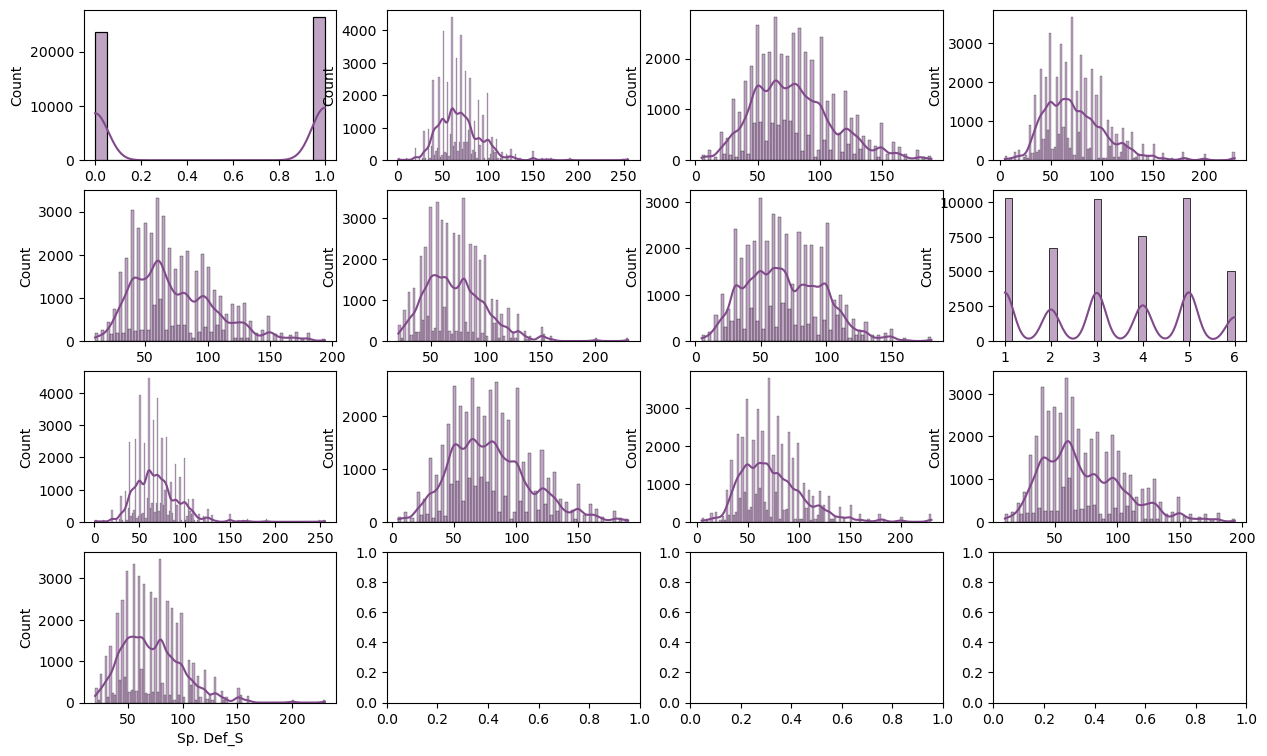

In [61]:
# Estraiamo i dati numerici dal dataframe
numeric_cols: list[str] = df_combats.select_dtypes(include=['int64', 'float64']).columns.tolist()

fig, axes = plt.subplots(4, 4, figsize=(15, 9))
for idx, col in enumerate(numeric_cols):
    ax = axes.flat[idx]
    sb.histplot(df_combats[col], kde=True, ax=ax, color=bar_color)
plt.tight_layout()
plt.show()

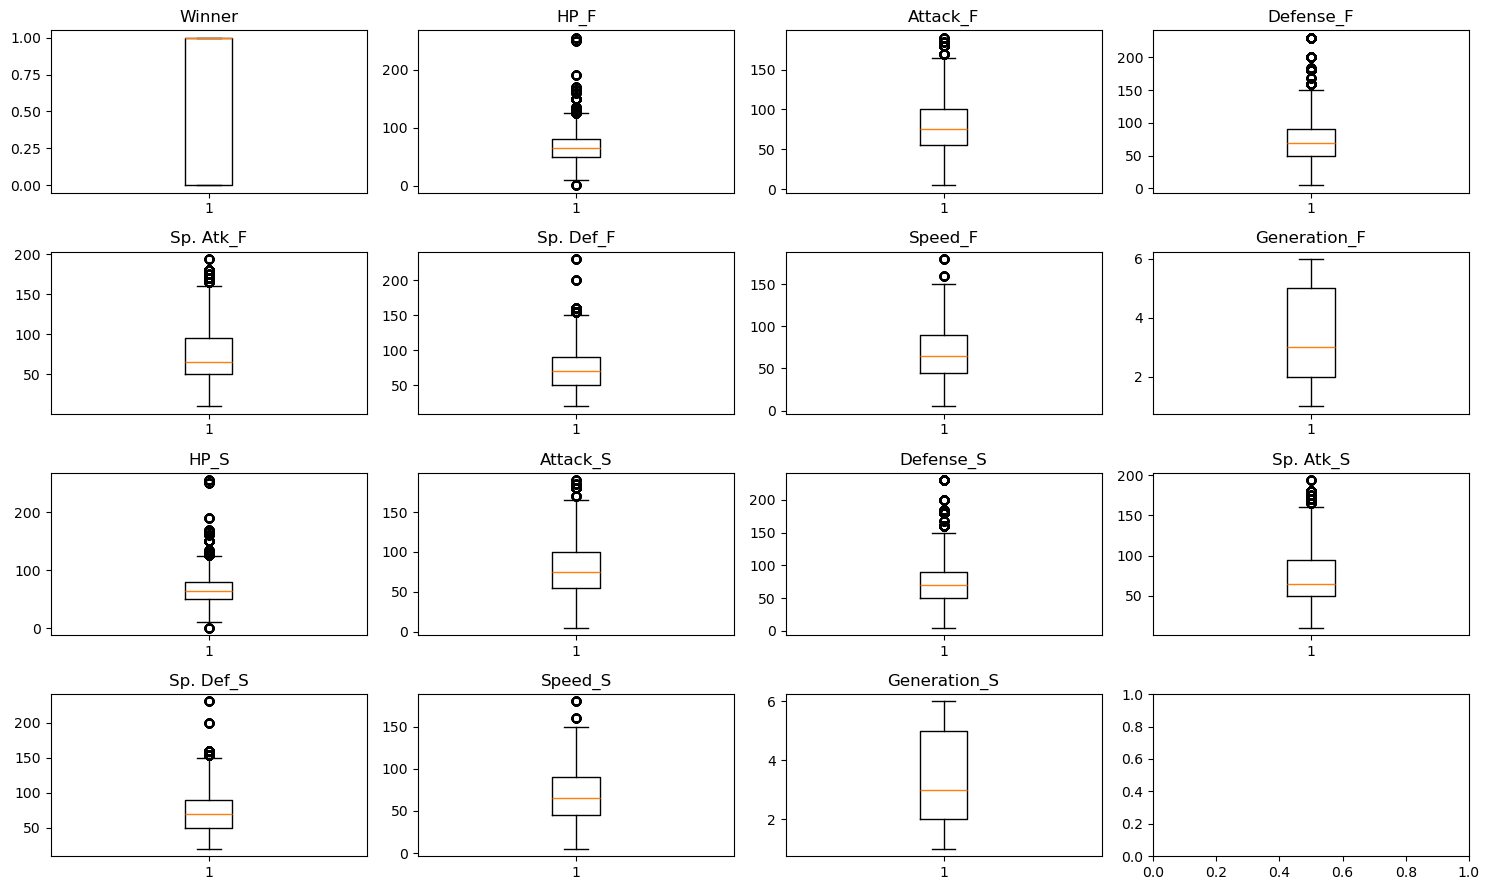

In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(15, 9))
for idx, col in enumerate(numeric_cols):
    ax = axes.flat[idx]
    ax.boxplot(df_combats[col])
    ax.set_title(col)
fig.tight_layout()
plt.show()

## Feature Engineering  <a id="feature-engineering"></a>

Abbiamo definito un trasformatore personalizzato utilizzando `FunctionTransformer` di Scikit-learn, progettato per elaborare un dataset contenente confronti tra coppie di Pokémon. La trasformazione utilizza un dataframe di riferimento (`dataframe_type_chart`) per calcolare i moltiplicatori di efficacia tra i tipi offensivi e difensivi, modellando le interazioni tra le combinazioni di tipo.

È importante sottolineare che, secondo la logica del gioco, il tipo di un Pokémon influisce sull’efficacia delle mosse e **non direttamente sulle sue statistiche**. Poiché il nostro dataset non include le mosse effettivamente utilizzate dagli sfidanti, sarà necessario valutare empiricamente quanto il tipo influenzi l'esito dello scontro.

La funzione, inoltre, sostituisce le statistiche individuali dei due Pokémon (es. `Attack_F` e `Attack_S`) con le rispettive differenze (es. `delta_Attack`), riducendo la dimensionalità del dataset e facilitando l’interpretazione dei dati. Infine, vengono rimosse colonne ridondanti o non informative, come i nomi e le generazioni dei Pokémon.

In [ ]:
from utils import function_transformer
data_transformer: FunctionTransformer = \
    FunctionTransformer(func=function_transformer, kw_args={'dataframe_type_chart': df_type_chart}).set_output(transform="pandas")

## Analisi delle Correlazioni <a id="analisi-delle-correlazioni"></a>

Applichiamo il trasformatore personalizzato al dataset. visualizziamo la matrice di correlazione tra le variabili numeriche del dataset df_combats_transformed. La matrice di correlazione mostra il grado di relazione lineare tra coppie di variabili, con valori compresi tra -1 (correlazione negativa perfetta) e 1 (correlazione positiva perfetta). Viene applicata una maschera triangolare superiore per evitare di mostrare valori duplicati, dato che la matrice è simmetrica. Infine, la matrice viene rappresentata graficamente con una heatmap per facilitare l’analisi visiva delle correlazioni.

In [ ]:
df_combats_transformed: pd.DataFrame = data_transformer.fit_transform(df_combats)

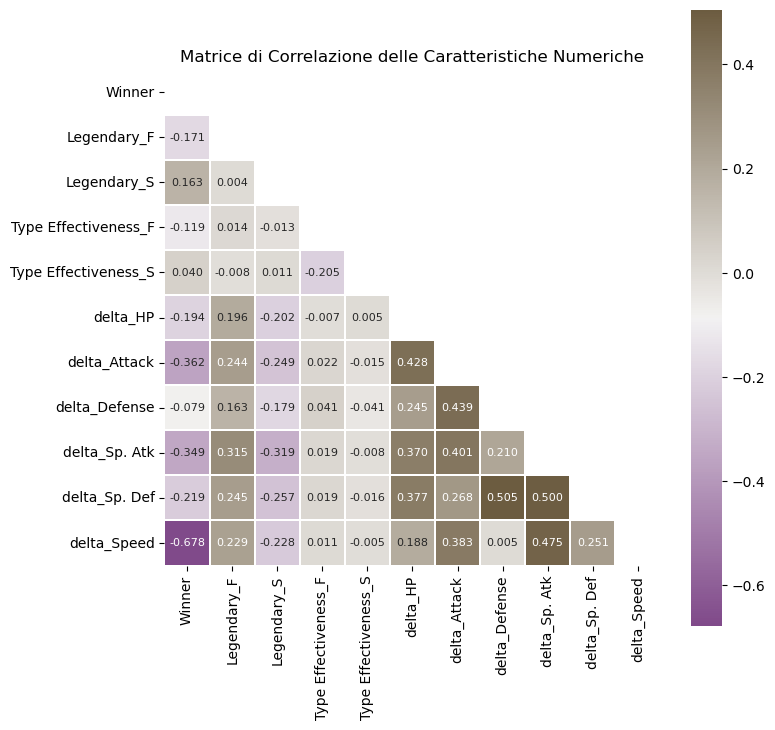

In [ ]:
numerical_dataset_correlation: pd.DataFrame = df_combats_transformed.corr()
# Creazione di una maschera per rimuovere valori duplicati nella matrice di correlazione (simmetrica)
mask: np.ndarray = np.zeros_like(numerical_dataset_correlation, dtype=bool)
mask[np.triu_indices_from(mask)] = True
# Plotting della matrice di correlazione
plt.figure(figsize=(8, 8))
plt.title("Matrice di Correlazione delle Caratteristiche Numeriche")
sb.heatmap(numerical_dataset_correlation, mask=mask, annot=True, square=True, linewidths=0.1, cmap=cmap, fmt=".3f", annot_kws={"fontsize":8})
plt.show()

Esaminando la matrice di correlazione, notiamo che le feature con la maggiore correlazione rispetto alla variabile `Winner` sono `delta_Speed`, seguita da `delta_Attack` e `delta_Sp. Atk`. Questo suggerisce che le differenze nelle statistiche offensive e nella velocità abbiano un impatto significativo sull'esito del confronto.

Al contrario, le variabili legate alla `Type Effectiveness` mostrano una correlazione molto debole. Questo è coerente con il fatto che i nostri dataset **non includono le mosse effettivamente apprese dai Pokémon**, e quindi i tipi influenzano indirettamente il risultato.

In particolare, la forte rilevanza di `delta_Speed` può essere spiegata dal meccanismo di gioco: il Pokémon con velocità maggiore attacca per primo e può avere l’opportunità di colpire più volte, ottenendo così un vantaggio strategico decisivo.

Creiamo un pairplot per visualizzare le relazioni tra le differenze statistiche (delta_*) dei due Pokémon e l’esito del duello (Winner). Ogni punto nel grafico rappresenta un match, colorato in base al vincitore, permettendo di osservare visivamente come le caratteristiche numeriche influenzano la vittoria. Sulla diagonale sono mostrate le distribuzioni di ciascuna variabile, mentre le combinazioni fuori diagonale rivelano possibili correlazioni e separazioni tra le classi. Questo tipo di visualizzazione è utile per individuare feature potenzialmente predittive.

<Figure size 1200x1200 with 0 Axes>

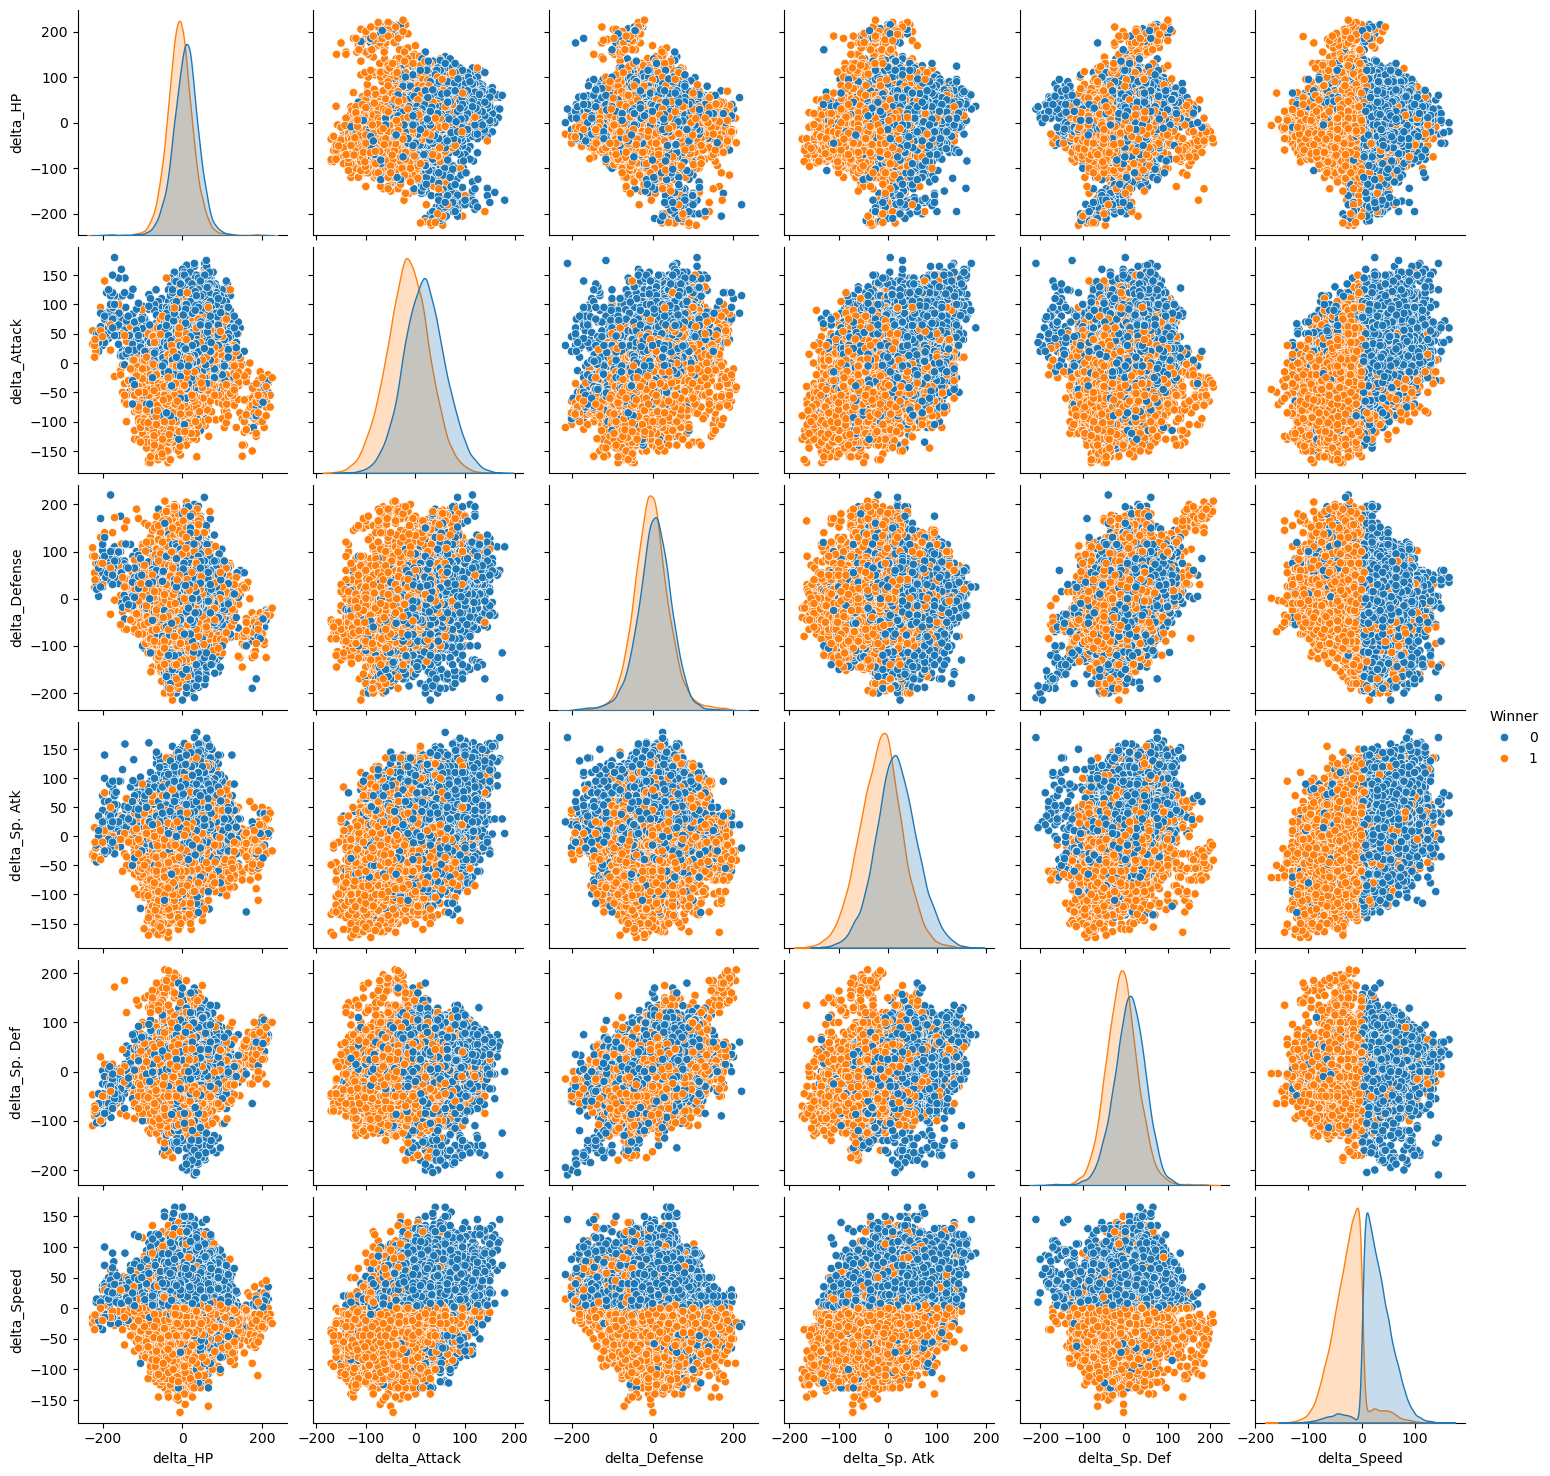

In [ ]:
# Plotting di un pairplot per visualizzare le relazioni tra le caratteristiche numeriche e il vincitore
plt.figure(figsize=(12, 12))
sb.pairplot(df_combats_transformed[['delta_HP', 'delta_Attack', 'delta_Defense', 'delta_Sp. Atk', 'delta_Sp. Def', 'delta_Speed', 'Winner']], hue="Winner")
plt.show()

A confermare quanto evidenziato precedentemente, dal pairplot osserviamo come delta_Speed mostra una buona separazione tra le classi: i Pokémon più veloci (con valori positivi) tendono a vincere più spesso, confermando l'importanza dell'iniziativa nel combattimento. Anche delta_Attack e delta_Sp. Atk mostrano una lieve tendenza: all’aumentare del valore, cresce la probabilità di vittoria.

# Addestramento e Tuning dei Modelli <a id="addestramento-e-tuning-dei-modelli"></a>

Per poter addestrare e valutare correttamente i nostri modelli di machine learning, è fondamentale suddividere il dataset a disposizione in sottoinsiemi distinti. Questo processo ci permette di simulare come il modello si comporterebbe su dati nuovi, fornendo una stima più realistica delle sue performance.

### Suddivisione del Dataset

Il codice sottostante implementa una strategia di suddivisione in tre parti: **training set**, **validation set** e **test set**.

1.  **Separazione Iniziale (Test Set)**  
Inizialmente, separiamo la variabile target `Winner` (ciò che vogliamo predire, `y`) dalle features (le variabili usate per la predizione, `X`).  
    Successivamente, una porzione del dataset (definita da `TEST_SIZE`) viene messa da parte come **test set** (`X_test`, `y_test`). Questo set verrà utilizzato **solo alla fine** del processo di sviluppo del modello per ottenere una valutazione finale e imparziale delle sue prestazioni.
    * `random_state=RANDOM_STATE`: Garantisce che la suddivisione sia la stessa ogni volta che il codice viene eseguito, rendendo i risultati riproducibili.
    * `stratify=y`: Assicura che la proporzione delle classi nella variabile target `y` sia mantenuta sia nel set temporaneo (`X_temp`, `y_temp`) che nel test set. Questo è cruciale in problemi di classificazione, specialmente con classi sbilanciate, per evitare che uno dei set contenga una rappresentazione distorta delle classi.

2.  **Separazione Training e Validation Set**  
    Il restante dataset temporaneo (`X_temp`, `y_temp`) viene a sua volta suddiviso in:  
    * **Training set** (`X_train`, `y_train`): Utilizzato per addestrare il modello. Il modello "impara" dai pattern presenti in questi dati.  
    * **Validation set** (`X_val`, `y_val`): Utilizzato durante la fase di sviluppo per la messa a punto degli iperparametri del modello (tuning) e per confrontare le performance di diversi modelli. Questo aiuta a prevenire l'overfitting sul training set. La dimensione è calcolata in modo da rispettare la proporzione `VALIDATION_SIZE` rispetto al dataset originale. Anche qui, `stratify=y_temp` mantiene la proporzione delle classi.

In [ ]:
# Funzione per addestrare i modelli e calcolare il punteggio
def train_and_score(pipeline, X_train, y_train, X_test, y_test):
    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_test)
    return accuracy_score(y_test, preds)

# Creazione del dataset di addestramento e test
y: pd.Series = df_combats['Winner']
X: pd.DataFrame = df_combats.drop(columns=['Winner'])
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=VALIDATION_SIZE / (1.0 - TEST_SIZE),
    random_state=RANDOM_STATE,
    stratify=y_temp
)

### Preprocessing dei Dati
Si procede alla preparazione delle feature prima dell’addestramento del modello. In particolare, si distinguono le variabili numeriche da quelle categoriche, e si applicano trasformazioni appropriate a ciascun tipo.

`labels_categoriche`: contiene i nomi delle variabili categoriche del dataset. In questo caso, si tratta di variabili booleane che indicano se il primo (F) o il secondo (S) Pokémon coinvolto nel combattimento è leggendario. Tali variabili sono fondamentali poiché l’essere leggendario è spesso associato a migliori statistiche di base.

`processed_numerical_columns`: tramite select_dtypes, vengono selezionate automaticamente tutte le colonne numeriche da preprocessare. Questo garantisce una scalabilità automatica del codice al variare delle feature numeriche presenti in X.

ColumnTransformer:

Utilizza due trasformatori principali:

* `StandardScaler()` per normalizzare tutte le feature numeriche, centrando le distribuzioni intorno allo 0 con varianza unitaria. Questo è particolarmente utile per modelli sensibili alle scale (es. SVM, regressione logistica).

* `OneHotEncoder(drop='first')` per convertire le feature categoriche in variabili dummy, evitando la trappola della multicollinearità rimuovendo la prima categoria.

L’opzione `sparse_output=False` impone un output denso per compatibilità con pipeline che non gestiscono bene matrici sparse.

`sparse_threshold=0.0` assicura che anche in presenza di feature categoriche, l’output sia denso e uniforme per tutte le trasformazioni.

In [ ]:
# Codifica delle variabili categoriche
# Otteniamo le label delle variabili categoriche
labels_categoriche: list[str] = ['Legendary_F', 'Legendary_S']
# Preprocessing delle variabili categoriche e numeriche
processed_numerical_columns: list[str] = df_combats_transformed.drop(columns=["Winner"]).select_dtypes(include=np.number).columns.tolist();
column_encoder: ColumnTransformer = ColumnTransformer(
    transformers=[
    ("numeric", StandardScaler(), processed_numerical_columns),
    ("categorical", OneHotEncoder(drop='first', sparse_output=False), labels_categoriche),
], sparse_threshold=0.0)

Si implementa un **modello dummy**, che funge da **baseline** per confrontare le prestazioni degli altri modelli più complessi. Non apprende nulla dai dati, ma produce previsioni casuali in base a una strategia predefinita.

In [ ]:
# Modello dummy
dummy_model: Pipeline = Pipeline([
    ('data_transformer', data_transformer),
    ('column_encoder', column_encoder),
    ('classifier', DummyClassifier(strategy='uniform', random_state=RANDOM_STATE))
])

Si implementa un **modello lineare** tramite **regressione logistica** con penalizzazione L1 (noto anche come Lasso Logistic Regression). Questo tipo di modello è particolarmente utile per la **selezione automatica delle feature** e per garantire **sparsità** nei coefficienti, migliorando interpretabilità e generalizzazione.

Viene usato:

* `penalty='l1'`: applica una penalizzazione L1 ai coefficienti, inducendo molti di essi a zero. Questo è utile quando si vuole automatizzare la selezione delle feature, lasciando solo quelle più informative.

* `solver='liblinear'`: è l’algoritmo ottimizzatore compatibile con la penalizzazione L1. È adatto a dataset di dimensioni contenute o moderate e garantisce una buona convergenza.

In [ ]:
# Modello lineare
linear_model: Pipeline = Pipeline([
    ('data_transformer', data_transformer),
    ('column_encoder', column_encoder),
    ('logistic_l1', LogisticRegression(penalty='l1', solver='liblinear'))
])

Si implementa un **modello di classificazione basato su Random Forest**, una delle tecniche di machine learning supervisionato più robuste e diffuse, in particolare per problemi di classificazione binaria come la previsione del vincitore in una battaglia Pokémon.

È un modello ensemble che costruisce molteplici alberi decisionali e li combina per migliorare l'accuratezza e ridurre l'overfitting.

L'argomento `n_estimators=100` specifica il numero di alberi nella foresta, garantendo una buona capacità di generalizzazione.

Il parametro `random_state` assicura ripetibilità dell’esperimento.

In [ ]:
# Modello decision tree
decision_tree_model: Pipeline = Pipeline([
    ('data_transformer', data_transformer),
    ('column_encoder', column_encoder),
    ("tree", RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE))
])

Si implementa un modello predittivo avanzato tramite **XGBoost (Extreme Gradient Boosting)**, uno degli algoritmi più performanti e utilizzati nel machine learning moderno, specialmente in contesti competitivi e industriali.

E' una variante estremamente efficiente del Gradient Boosting Decision Tree (GBDT).

Il parametro `eval_metric='logloss'` specifica la funzione di perdita da minimizzare durante il training, adatta a problemi di classificazione binaria.



In [ ]:
# Modello xgboost
xgboost_model: Pipeline = Pipeline([
   ('data_transformer', data_transformer),
   ('column_encoder', column_encoder),
   ("xgboost", XGBClassifier(eval_metric='logloss', random_state=RANDOM_STATE))
])

Quando si costruisce un modello di machine learning, come XGBoost, la sua performance dipende molto dai parametri iper (o iperparametri) che regolano il comportamento del modello. Tali parametri non vengono appresi automaticamente dal modello durante il training, ma devono essere impostati a priori dall’utente.

Esempi di iperparametri in XGBoost sono:

* n_estimators: numero di alberi da costruire (numero di iterazioni boosting).

* max_depth: profondità massima di ogni albero.

* learning_rate: velocità con cui il modello si adatta agli errori.

La grid search è un metodo esaustivo per trovare la miglior combinazione di iperparametri da un insieme predefinito di valori. 

Per valutare la robustezza della performance di ogni combinazione, si usa la cross-validation:

* Il dataset di training viene diviso in k-fold

* Il modello viene allenato e valutato 3 volte, ogni volta usando un fold diverso per la validazione e gli altri due per l’allenamento.

* La performance finale è la media delle 3 valutazioni.

`grid_xgb.best_estimator_ ` è il modello completo, addestrato con i parametri ottimali, pronto per essere usato su dati nuovi.

In [ ]:
# Creazione di una griglia di ricerca per ottimizzare i parametri del modello XGBoost
param_grid: dict = {
   'xgboost__n_estimators': [200, 300, 400],
   'xgboost__max_depth': [8, 9, 10],
   'xgboost__learning_rate': [0.05, 0.1, 0.15]
}
grid_xgb: GridSearchCV = GridSearchCV(xgboost_model, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid_xgb.fit(X_val, y_val)
print(f"Best parameters: {grid_xgb.best_params_}")
# Modello xgboost
xgboost_grid_model: Pipeline = grid_xgb.best_estimator_

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters: {'xgboost__learning_rate': 0.05, 'xgboost__max_depth': 10, 'xgboost__n_estimators': 400}


In [ ]:
# Addestramento e valutazione dei modelli creati
models: list = [dummy_model, linear_model, decision_tree_model, xgboost_model, xgboost_grid_model]
model_names: list = ['Dummy', 'Logistic Regression', 'Decision Tree', 'XGBoost', 'XGBoost with Grid Search']
# Visualizzazione dei risultati dei modelli
for model, name in zip(models, model_names):
   score: float = train_and_score(model, X_train, y_train, X_test, y_test)
   print(f"{name} score: {score:.4f}")

Dummy score: 0.5035
Logistic Regression score: 0.8762
Decision Tree score: 0.9546
XGBoost score: 0.9527
XGBoost with Grid Search score: 0.9538


In [ ]:
# Salvataggio dei modelli
if not os.path.exists('models'):
   os.makedirs('models')

for model, name in zip(models, model_names):
   print(f"Saving model: {name}")
   joblib.dump(model, f'models/{name.replace(" ", "_").lower()}.joblib')

Saving model: Dummy
Saving model: Logistic Regression
Saving model: Decision Tree
Saving model: XGBoost
Saving model: XGBoost with Grid Search


# Valutazione dei Modelli <a id="valutazione-dei-modelli"></a>

In [ ]:
model_names = ['Dummy', 'Logistic Regression', 'Decision Tree', 'XGBoost', 'XGBoost Optimized']

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

def extended_validation(model, X_test, y_test, title):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    print(title)
    print(classification_report(y_test, y_pred))
    
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    if y_proba is not None:
        print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

# Applica a tutti i modelli
for i, model in enumerate(models[1:]):
    model.fit(X_train, y_train) # Ri-addestra su tutto il training set
    extended_validation(model, X_test, y_test, title=f"Classification Report: {model_names[i+1]}")

Classification Report: Logistic Regression
              precision    recall  f1-score   support

           0       0.87      0.86      0.87      4720
           1       0.88      0.89      0.88      5280

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

Confusion Matrix:
[[4069  651]
 [ 587 4693]]
ROC AUC Score: 0.9248
Classification Report: Decision Tree
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      4720
           1       0.96      0.96      0.96      5280

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000

Confusion Matrix:
[[4492  228]
 [ 226 5054]]
ROC AUC Score: 0.9904
Classification Report: XGBoost
              precision    recall  f1-score   support

           0       0.95      0.95      0.95   

Importanza delle feature

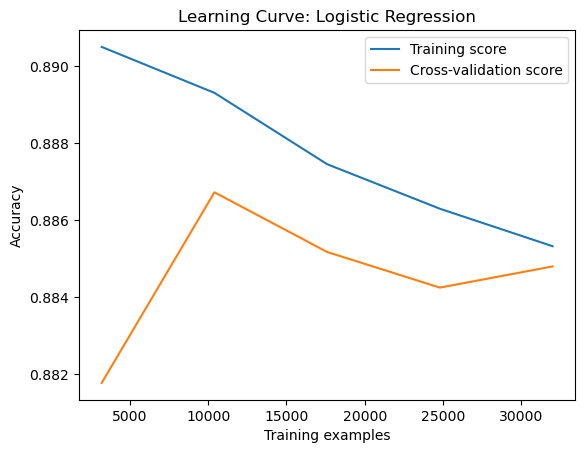

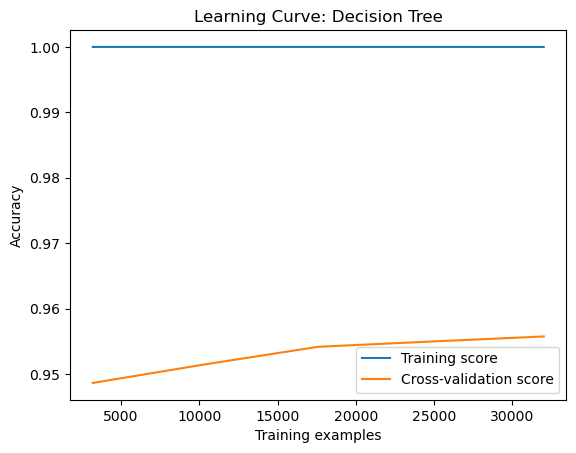

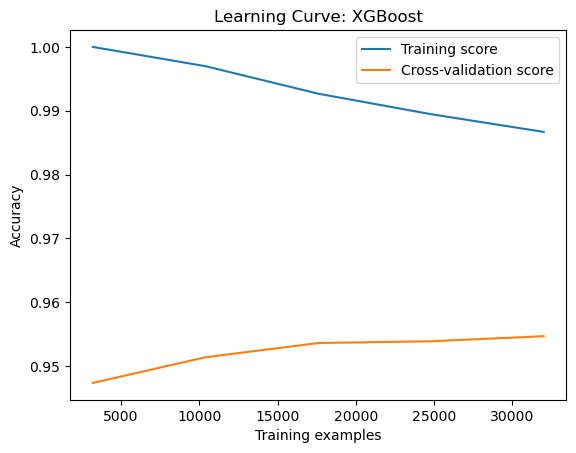

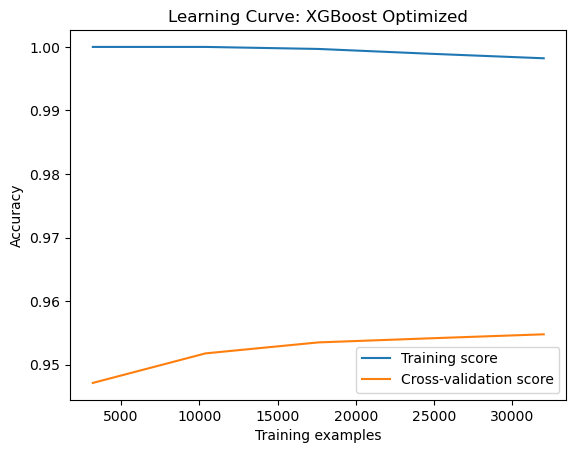

In [ ]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

def plot_learning_curve(model, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, n_jobs=-1, 
        train_sizes=np.linspace(0.1, 1.0, 5),
        scoring='accuracy'
    )
    
    plt.figure()
    plt.plot(train_sizes, np.mean(train_scores, axis=1), label="Training score")
    plt.plot(train_sizes, np.mean(test_scores, axis=1), label="Cross-validation score")
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title(title)
    plt.show()

for i, model in enumerate(models[1:]):  # Escludi dummy model
    plot_learning_curve(
        model, 
        X_temp, 
        y_temp,
        title=f"Learning Curve: {model_names[i+1]}"
    )